#Exploring Sleep Debt & Health Markers

Literature shows that the type of good health I seek, that of a physically fit athlete, is best examined with the following rubric.

1. According to Wikipedia: "Sleep debt or sleep deficit is the cumulative effect of not getting enough sleep. A large sleep debt may lead to mental or physical fatigue. There are two kinds of sleep debt: the results of partial sleep deprivation and total sleep deprivation." My biggest concern is that sleep deprivation is an indicator of brain degeneration in the elderly. My goal is to work on trending my sleep debt down through sleep hygiene techniques.
2. Resting heart rate (RHR) can be the result of a high level of fitness, meditative breathing, and sleep. There are other reasons, such as disease, diet, family history, and medication, which can result in a low resting heart rate. For my health purposes, I expect to see that when I am healthy and doing self-care (such as meditation, high cardio workouts, sleep hygiene, etc.), my resting heart rate will be relatively steady. And if trends present themselves, the RHR will be trending down.
3. Maximum heart rate (MHR) is the number of beats the heart makes during strenuous exercise. While a high heart rate can be a sign of a medical issue, it is also an indicator of good health. If during use, the heart beats more often as a result of the exercise, it can be a sign of proper conditioning. There is always a countervailing pressure that as the heart becomes more conditioned, it beats slower. My goal is to grow my MHR or at least stay on an even trendline.
4. Heart rate variability (HRV) is the interplay between the sympathetic and parasympathetic branches of the autonomic nervous system. During relaxation, the HRV goes up, and during stress and exercise, the HRV goes down. HRV plays a role as a good indicator of recovery from illness, anxiety, and training. My goal is to drive my average HRV score up over time.
5. Calories burned beyond primary body function are an indication of a strengthened heart which lowers the RHR, encourages the MHR upward, and promotes healthy sleep patterns.
6. REM sleep is a phase of sleep that lasts approximately 25% of any sleep period. It is commonly associated with the processing of learning, memory, and emotional state. Excessive strain, alcohol, and medical issues can suppress REM sleep. While there are exceptions due to circumstances of medicines, drink, and illness, a healthy sleep pattern should involve rough parity between time spent in REM and deep sleep.
7. Deep sleep, or slow-wave sleep, is a phase of sleep most commonly associated with the body recovering from physical exertion during the previous awake period. Excessive strain, alcohol, and medical issues can suppress deep sleep (also called delta wave sleep). While there are exceptions due to circumstances of medicines, alcohol, and illness, a healthy sleep pattern should involve rough parity between time spent in REM and deep sleep.

##Personal Fitness Markers

This study uses personal fitness markers I gathered over the period between January 1, 2018, and February 7, 2020. These two+ years constitute a big transition in my life between being able to devote a reasonable amount of time and effort to my physical fitness, through some bad injuries, and into a change of life direction into less physical exercise due to injury. These markers were gathered daily through a fitness tracker from Whoop and other methods.  

###Loading libraries, methods, and data for examination.

In [0]:
#import libraries and methods
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from IPython.display import display, HTML

In [0]:
%%capture
!pip install category_encoders
import category_encoders as ce

In [0]:
#set some options for the notebook

pd.options.display.max_rows = 50
pd.options.mode.chained_assignment = None

In [0]:
#Import the data from a live Google spreadsheet in CSV. This file is updated regularly.

df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTMIUP6_JIoxWSAFCe1h6Hz12r-41t6qHv5cCXIBmYJUK2KS188pKkZnkr4jJRpIcC3mRZV36z21oNv/pub?gid=0&single=true&output=csv')

In [0]:
#Adding a proper header to the file. Going to do some feature engineering, adding columns, 
#re-setting index.

header_list = ['Date','Weight','Fat','Sleep Debt','REM','Deep Sleep','Snore',
     'Meditate','Spanish','Push-ups','Pull-ups','Sit-ups','Coffee','Handstands',
     'Acro','Swing','Strain','Calories','AHR','MHR','HRV','RHR','Recovery',
     'Carbs','Journal','Spinal Mobility','Flexibility','Notes','DOW',
     'Weight_AVR','Fat_AVR','Sleep Debt_AVR','REM_AVR','Deep Sleep_AVR',
     'Strain_AVR','Calories_AVR','AHR_AVR','MHR_AVR','HRV_AVR','RHR_AVR',
     'Recovery_AVR','Weight_PASS','Fat_PASS','Sleep Debt_PASS','REM_PASS',
     'Deep Sleep_PASS','Strain_PASS','Calories_PASS','AHR_PASS','MHR_PASS',
     'HRV_PASS','RHR_PASS','Recovery_PASS']

df = df.reindex(columns = header_list)

###Feature engineering & data organization

In [0]:
#Setting date column to pandas datetime object and then engineering a day of the week feature.

df['Date'] = pd.to_datetime(df['Date'])

for i in range(len(df)):
    df['DOW'][i] = df['Date'][i].day_name()

In [0]:
#Lists of features to be used in analysis. These are subsets of header_list.

features = ['Weight','Fat','Sleep Debt','REM','Deep Sleep','Strain','Calories',
            'AHR','MHR','HRV','RHR','Recovery']

special_features = ['Sleep Debt','AHR','RHR']

#Note: Dropping DOW which was engineered directly above.
drops = ['Acro','Meditate','Snore','Coffee','Handstands','Spanish','Push-ups',
         'Pull-ups','Sit-ups','Swing','Carbs','Journal','Spinal Mobility',
         'Flexibility','Notes','DOW']

week_day = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

In [0]:
#Dropping columns which will not be used in this iteration of this analysis.

df = df.drop(labels=drops,axis=1)

In [0]:
#Interpolating columns for missing values. 

for each in features:
    df[each] = df[each].interpolate(method='linear')

In [0]:
#Engineering an average column for each feature.

for i in range(0,df.shape[0]-1):
    for j in range(len(features)):
        string = features[j] + '_AVR'
        df[string] = df.iloc[:,j+1].expanding(min_periods=7).mean()

In [0]:
#Using these averages to create a new feature which promotes the marker responses I seek.
#For instance I want my sleep debt to be rewarded for going below the average while I want 
#my MHR to be rewarded for rising. This column will be part of my predictive modeling.

for i in range(len(df)):
  for feat in features:
    score = feat + '_PASS'
    avr = feat + '_AVR'
    if feat not in special_features:
      if df[feat][i] >= df[avr][i]:
        df[score][i] = 1
      else:
        df[score][i] = 0
    elif feat in special_features:
      if df[feat][i] <= df[avr][i]:
        df[score][i] = 1
      else:
        df[score][i] = 0

##Visualizations of basic trends.

In [0]:
sleep = df[(df['Date'] >= '04/01/2018')]
#sleep = df[(df['Date'] >= '01/06/2018')]
#sleep = df[(df['Date'] >= '11/24/2019')]

In [107]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=sleep.Date, y=sleep['REM_AVR'], name="REM",
                         line_color='greenyellow'))

fig.add_trace(go.Scatter(x=sleep.Date, y=sleep['Deep Sleep_AVR'], name="Deep Sleep",
                         line_color='turquoise'))

fig.add_trace(go.Scatter(x=sleep.Date, y=sleep['Sleep Debt_AVR'], name="Sleep Debt",
                         line_color='deepskyblue'))

fig.update_layout(title_text='Sleep Hygiene Progress April 2018 through February 2020',
                  xaxis_rangeslider_visible=False,
                  xaxis_title="",
                  yaxis_title="Minutes")

fig.show()

###Visualization of REM & Deep Sleep Flip Post Concussion

On April 21, 2019 I received a vlow on my head from a random tricker who did a back flip onto my head and right shoulder as I was walking along. He knocked me out instantly. I remained knocked out for 45 seconds and was subsequently taken to an ER for examination and treatment. I suffered from the results of this injury for several months and was subsequently injured again in August. I did not fully recover from all of this until December 2019. I am interested in examining the time immediately after the accident and made this quick sketch to give myself some insight into that event which effected me so much. Notice that my sleep debt went to 0 on the 23rd and 24th of April as the full effects of the accident took hold of me and did nothing but sleep. On the 25th I decided to resume my normal life and became active again. It turns out this was a big mistake and likely contributed to my long recovery.

In [161]:
concuss = df[(df['Date'] <= '04/30/2019') & (df['Date'] >= '04/21/2019')]

fig = go.Figure()
fig.add_trace(go.Scatter(x=concuss.Date, y=concuss['REM'], name="REM",
                         line_color='dimgray'))

fig.add_trace(go.Scatter(x=concuss.Date, y=concuss['Deep Sleep'], name="Deep Sleep",
                         line_color='rosybrown'))

fig.add_trace(go.Scatter(x=concuss.Date, y=concuss['Sleep Debt'], name="Sleep Debt",
                         line_color='deepskyblue'))


fig.update_layout(title_text='Visualization of REM & Deep Sleep Flip Post Concussion',
                  xaxis_rangeslider_visible=False)
fig.show()

##Predictive Modeling

In [109]:
df['REM_AVR'][753]

71.42440318302387

###Random Forest Categorical Predictive Modeling

In [0]:
#Create train, validation, & test sets.

test = df[df['Date'] >= '11/20/2019']
train = df[(df['Date'] <= '07/24/2019') & (df['Date'] >= '02/13/2018')]
val = df[(df['Date'] <= '11/19/2019') & (df['Date'] >= '07/25/2019')]

#test = df[df['Date'] >= '11/23/2019']
#train = df[(df['Date'] <= '06/24/2019') & (df['Date'] >= '01/06/2018')]
#val = df[(df['Date'] <= '11/22/2019') & (df['Date'] >= '06/23/2019')]

In [0]:
test = test.drop(labels=['Sleep Debt','HRV_PASS','AHR_PASS','MHR_PASS',
                         'RHR_PASS','Deep Sleep_PASS','Recovery_PASS',
                         'Strain_PASS','Weight_PASS','Calories_PASS',
                         'Fat_PASS','Recovery_AVR','Recovery','Strain'],axis=1)
train = train.drop(labels=['Sleep Debt','HRV_PASS','AHR_PASS','MHR_PASS',
                         'RHR_PASS','Deep Sleep_PASS','Recovery_PASS',
                         'Strain_PASS','Weight_PASS','Calories_PASS',
                         'Fat_PASS','Recovery_AVR','Recovery','Strain'],axis=1)
val = val.drop(labels=['Sleep Debt','HRV_PASS','AHR_PASS','MHR_PASS',
                         'RHR_PASS','Deep Sleep_PASS','Recovery_PASS',
                         'Strain_PASS','Weight_PASS','Calories_PASS',
                         'Fat_PASS','Recovery_AVR','Recovery','Strain'],axis=1)

In [112]:
test.shape, train.shape, val.shape

((79, 23), (527, 23), (118, 23))

Target & Features

In [0]:
target = 'Sleep Debt_PASS'
# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 25].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [0]:
#Begin setting up models

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [115]:
#Find baseline

y_train.value_counts(normalize=True)

1.0    0.523719
0.0    0.476281
Name: Sleep Debt_PASS, dtype: float64

In [0]:
#Set up initial pipeline

pipeline = make_pipeline( 
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(max_features='sqrt',n_estimators=175,n_jobs=-1, random_state=42)
)

In [117]:
#Fit & score on validation set.
pipeline.fit(X_train, y_train)

print('Validation Accuracy:', pipeline.score(X_val, y_val))

Validation Accuracy: 0.6694915254237288


In [0]:
#Prediction set for test score.

y_pred = pipeline.predict(X_test)

In [119]:
#Quick check on prediction array. Visually this is an error check as it should 
#not be either all '1' or all '0'.

y_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [120]:
#Score on test set  
print('Test Accuracy:',pipeline.score(X_test,y_test))

Test Accuracy: 0.27848101265822783


##Get feature importances

Learning here the outsized role that REM plays is really interesting. The averages of all of these other features play an outsized role in comparison to the most recent entry for everything but REM where it is reversed. This leads me to believe there is a strong correlation between the REM duration on any given night which is not overwhelmed by any other current feature. Really fascinating.

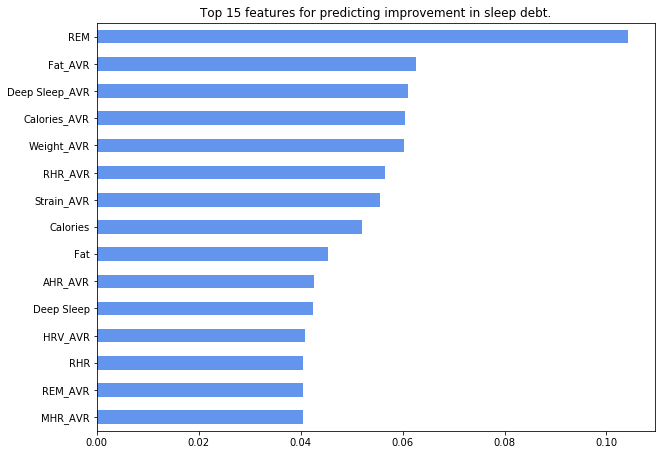

In [121]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

n = 15
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features for predicting improvement in sleep debt.')
importances.sort_values()[-n:].plot.barh(color='cornflowerblue');

##Linear Regression

In [0]:
def lr(train, test, features, target):
    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    print(f'Linear Regression with {len(features)} features')
    print('Intercept', model.intercept_)
    coefficients = pd.Series(model.coef_, features)
    print(coefficients.to_string())
    
    print('Train Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred_train)))
    print('Test Root Mean Square Error:', np.sqrt(mean_squared_error(y_test, y_pred_test)))
    print('Train Mean Absolute Error:', mean_absolute_error(y_train, y_pred_train))
    print('Test Mean Absolute Error:', mean_absolute_error(y_test, y_pred_test))
    print('Train R^2 Score:', r2_score(y_train, y_pred_train))
    print('Test R^2 Score:', r2_score(y_test, y_pred_test))

In [123]:
target = 'Sleep Debt_PASS'
features = ['Weight','Fat','REM','Deep Sleep','Calories',
            'AHR','MHR','HRV','RHR']
lr(train, test, features, target)

Linear Regression with 9 features
Intercept 7.443208831397655
Weight       -0.068616
Fat           0.196888
REM           0.004677
Deep Sleep    0.000164
Calories      0.000013
AHR           0.006640
MHR           0.003849
HRV          -0.005400
RHR          -0.007401
Train Root Mean Squared Error: 0.4638124338099063
Test Root Mean Square Error: 0.4731570837493964
Train Mean Absolute Error: 0.4307362937583638
Test Mean Absolute Error: 0.44595065244154425
Train R^2 Score: 0.13757129959198222
Test R^2 Score: -0.1142107362486744


The RMSE for train versus test ( .4638124338099063, .4731570837493964 ) are comparable. This is an indication that my model is not over fit.

##ROC Curve

The false positive/true positive ratio seems in line with my model showing some level of useful information.

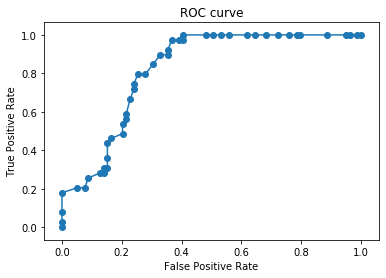

In [124]:
y_pred_proba = pipeline.predict_proba(X_val)[:, -1] # Probability for the last class
roc_auc_score(y_val, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})

plt.scatter(fpr, tpr)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

###Select K best for features

It appears that a minimum of 6 features are needed for my model. It's extremely curious to me that each of those features are averages of the past except for the current duration of REM on the night being predicted against.

In [125]:
for k in range(1, len(X_train.columns)+1):
    print(f'{k} features')

    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test Mean Absolute Error: {mae:,.0f} \n')

1 features
Test Mean Absolute Error: 0 

2 features
Test Mean Absolute Error: 0 

3 features
Test Mean Absolute Error: 0 

4 features
Test Mean Absolute Error: 0 

5 features
Test Mean Absolute Error: 0 

6 features
Test Mean Absolute Error: 1 

7 features
Test Mean Absolute Error: 1 

8 features
Test Mean Absolute Error: 1 

9 features
Test Mean Absolute Error: 1 

10 features
Test Mean Absolute Error: 1 

11 features
Test Mean Absolute Error: 1 

12 features
Test Mean Absolute Error: 1 

13 features
Test Mean Absolute Error: 1 

14 features
Test Mean Absolute Error: 1 

15 features
Test Mean Absolute Error: 1 

16 features
Test Mean Absolute Error: 1 

17 features
Test Mean Absolute Error: 1 

18 features
Test Mean Absolute Error: 1 

19 features
Test Mean Absolute Error: 1 

20 features
Test Mean Absolute Error: 1 

21 features
Test Mean Absolute Error: 1 



##Ridge Regression

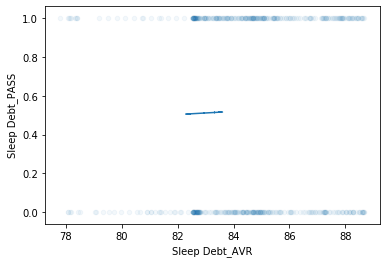

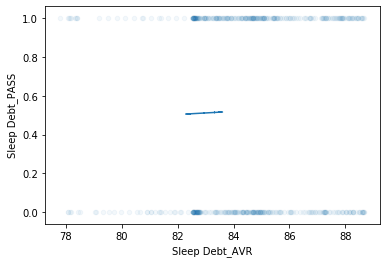

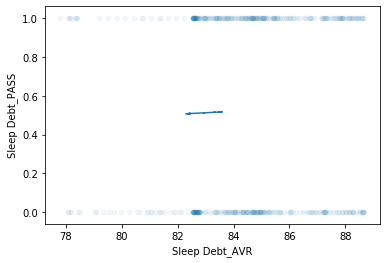

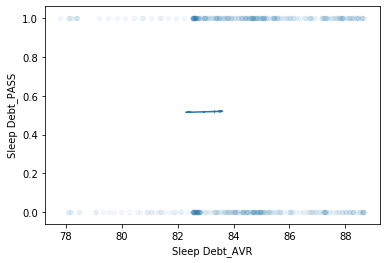

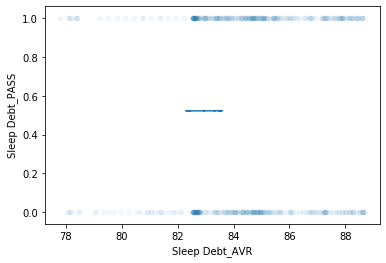

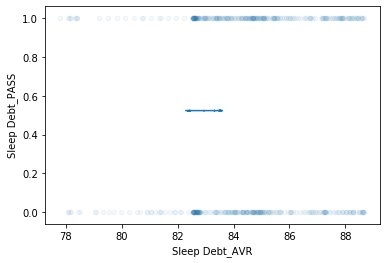

In [126]:
for alpha in [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]:
    
    # Fit Ridge Regression model
    feature = 'Sleep Debt_AVR'
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha, normalize=True)
    model.fit(X_train[[feature]], y_train)
    
    # Get Test MAE
    y_pred = model.predict(X_test[[feature]])
    mae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: {mae:,.0f}'))
    
    train.plot.scatter(feature, target, alpha=0.05)
    plt.plot(X_test[feature], y_pred)
    plt.show()

##Decision Tree Classifier

Ran a quick check on this model and it appears it just passes the baseline on validation by about 3%.

In [127]:
dt = make_pipeline(
    SimpleImputer(), 
    DecisionTreeClassifier(max_depth=16, random_state=42)
)

dt.fit(X_train, y_train)
print('Decision Tree:')
print('Train Accuracy', dt.score(X_train, y_train))
print('Validation Accuracy', dt.score(X_val, y_val))

Decision Tree:
Train Accuracy 1.0
Validation Accuracy 0.559322033898305


#Visualization Sketches

Following are a few sketches I made while exploring the data. These sketches helped me clarify my thoughts about what is going on with my health markers over this time span.


##Sleep Graphs

This is a sketch of a graph I then made a nicer version of near the top of the notebook. It is an extremely interesting graph as the first 280 or so days my REM and Deep Sleep(DS) are widely convergent. This is an indicator that I was not taking care of myself as I should. In actuality I was just trying to figure out how to sleep better and so it's not surprising that the graph would show such divergence. Nicely though as I was able to get a handle on my habits and learn more about sleep hygiene the REM and DS begin to entrain which reflects good sleep hygiene. In addition you can see as this happens my sleep debt begins to climb down. There is much to be learned. This graph just hints at what is to come with more data and more refinement of my habits.

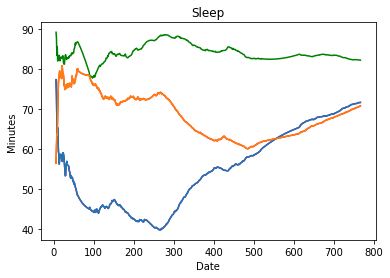

In [142]:
plt.plot(df['Deep Sleep_AVR'],color="red")
plt.plot(df['Sleep Debt_AVR'],color="green")
plt.plot(df['REM_AVR'],color="purple")

plt.title('Sleep')
plt.xlabel('Date')
plt.ylabel('Minutes');

Here's the same data without the inclusion of the Sleep Debt Average. This gives a slighter better vantage on the extreme divergence.

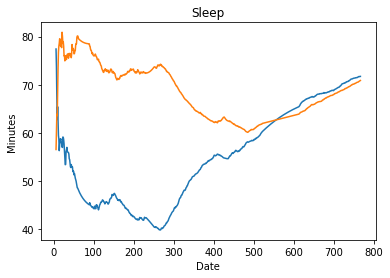

In [143]:
plt.plot(df['REM_AVR'])
plt.plot(df['Deep Sleep_AVR'])

plt.title('Sleep')
plt.xlabel('Date')
plt.ylabel('Minutes');

##Daily Heart Measurements

As you can see the Resting Heart Rate (RHR) lowers during this span of time while the Maximum Heart Rate (MHR) rises. This is exactly in line with my goal of improving my heart strength by exercise.

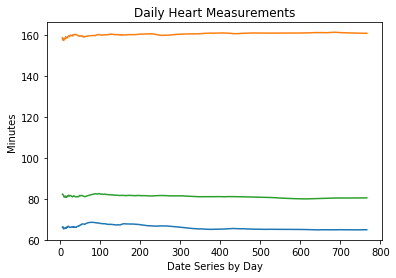

In [153]:
plt.plot(df['RHR_AVR'])
plt.plot(df['MHR_AVR'])
plt.plot(df['AHR_AVR'])
plt.title('Daily Heart Measurements')
plt.xlabel('Date Series by Day')
plt.ylabel('Minutes');

This graphs shows nicely the decline in my Resting Heart Rate (RHR) during this period of exploration. This is also in line with my goals of lowering my RHR


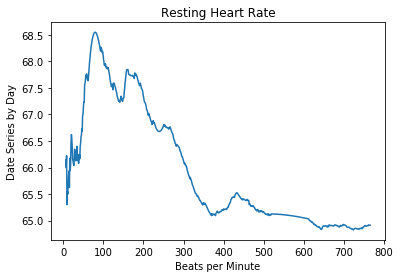

In [151]:
plt.plot(df['RHR_AVR'])
plt.title('Resting Heart Rate')
plt.xlabel('Beats per Minute')
plt.ylabel('Date Series by Day');

This graphs shows nicely the rise in my Maximum Heart Rate (MHR) due to increased exercise during this period of time. It tracks nicely with my intent to grow my strength and health.

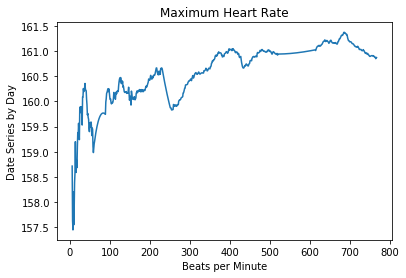

In [154]:
plt.plot(df['MHR_AVR'])
plt.title('Maximum Heart Rate')
plt.xlabel('Beats per Minute')
plt.ylabel('Date Series by Day');

##Heart Rate Variability

Heart Rate Variability (HRV) shows growth during this period. For proper health HRV should be kept as high as possible so this growth is exactly in line with my intentions during this period.

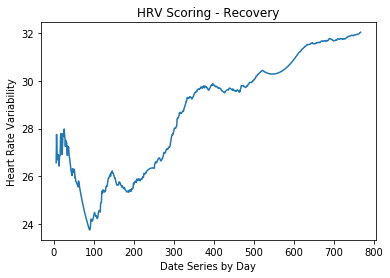

In [155]:
plt.plot(df['HRV_AVR'])
plt.title('HRV Scoring - Recovery')
plt.xlabel('Date Series by Day')
plt.ylabel('Heart Rate Variability');

#Calories Burned

This graph shows how the raw number of calories reported to have been burned per day during this period. The steep decline can be directly attributed to my concussion and the health issues which resulted. Sad to see this. But it's good to see a qualitative measurment of what i have been feeling. 

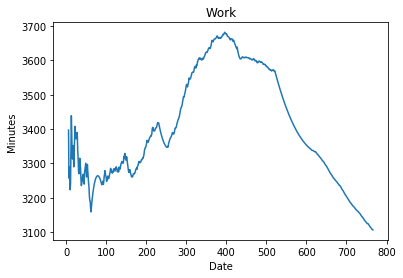

In [158]:
plt.plot(df['Calories_AVR'])
plt.title('Calories Burned per Day')
plt.xlabel('Date Series by Day')
plt.ylabel('Calories');

#Conclusion

While I found that my model can predict better sleep by 14% above baseline and that REM sleep duration is a key part of that my sample size is small and my model can be improved through more attention to hyperparameters. I look forward to refining this model as my sample size grows moving forward.

I removed a lot of features from my data set such as types of exercise, activities which contribute towards REM sleep, and other instances. In future iterations I will add additional features both from an engineering aspect as well as simply adding new ones such as alcohol consumption (which interferes with REM production.

It has been especially poignant examining this data through the lens of my recent injuries. Getting older and watching the body slow down is heart breaking. Hopefully with this additional knowledge and plan moving forward I can work back towards greater health and the type of intense physical activity that I enjoy so much.